<font size=+3>Using Time Series Analysis to predict the amount of passengers on a train</font>

Import the necessary libraries needed

In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
from sklearn import datasets
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv(r"C:\Users\user\Desktop\Data Science\YouTube-videos-public-main\arima-model-time-series-prediction-python\website_data.csv")

In [3]:
data.head()

,traffic
0,932
1,929
2,938
3,964
4,990


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<font size=+1>**Import matplot for plotting graph**</font>

In [5]:
import matplotlib.pyplot as plt

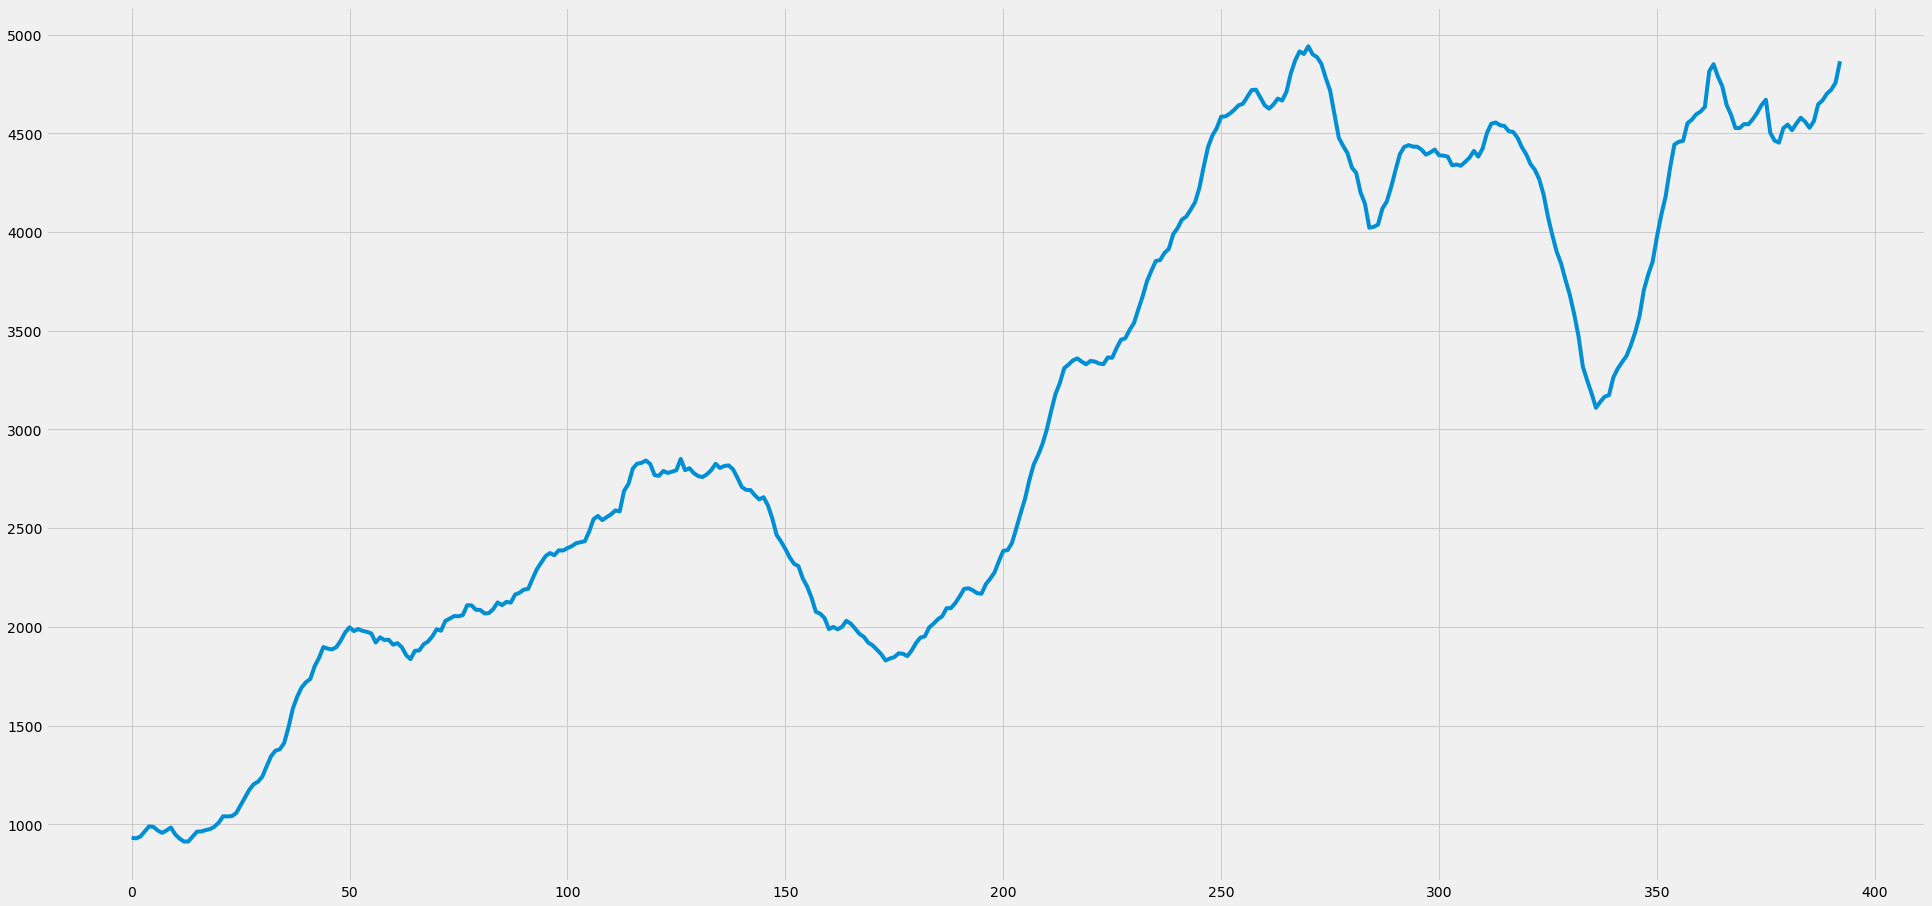

In [6]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (30, 15))
plt.plot(data.index, data['traffic'])

<font size=+1>**Decompose our data into trend, seasonal and residual, this also will shine more light into the stationarity of our Data**</font>

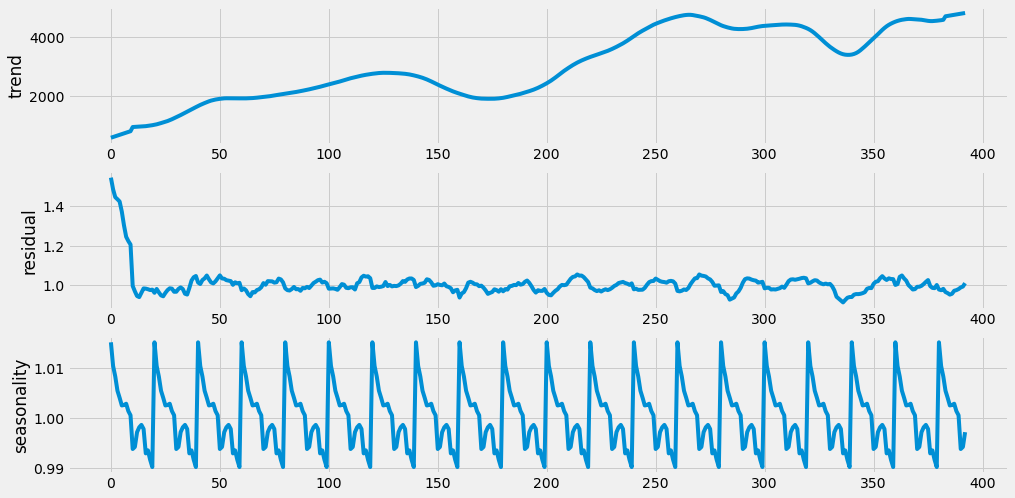

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['traffic'], model = 'multiplicative', filt = None, period=20, two_sided = True, extrapolate_trend = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
result.trend.plot(ax=ax1,ylabel = "trend")
result.seasonal.plot(ax=ax3,ylabel = "seasonality")
result.resid.plot(ax=ax2,ylabel = "residual")
plt.show()

Check for seasonality using the log of the traffic

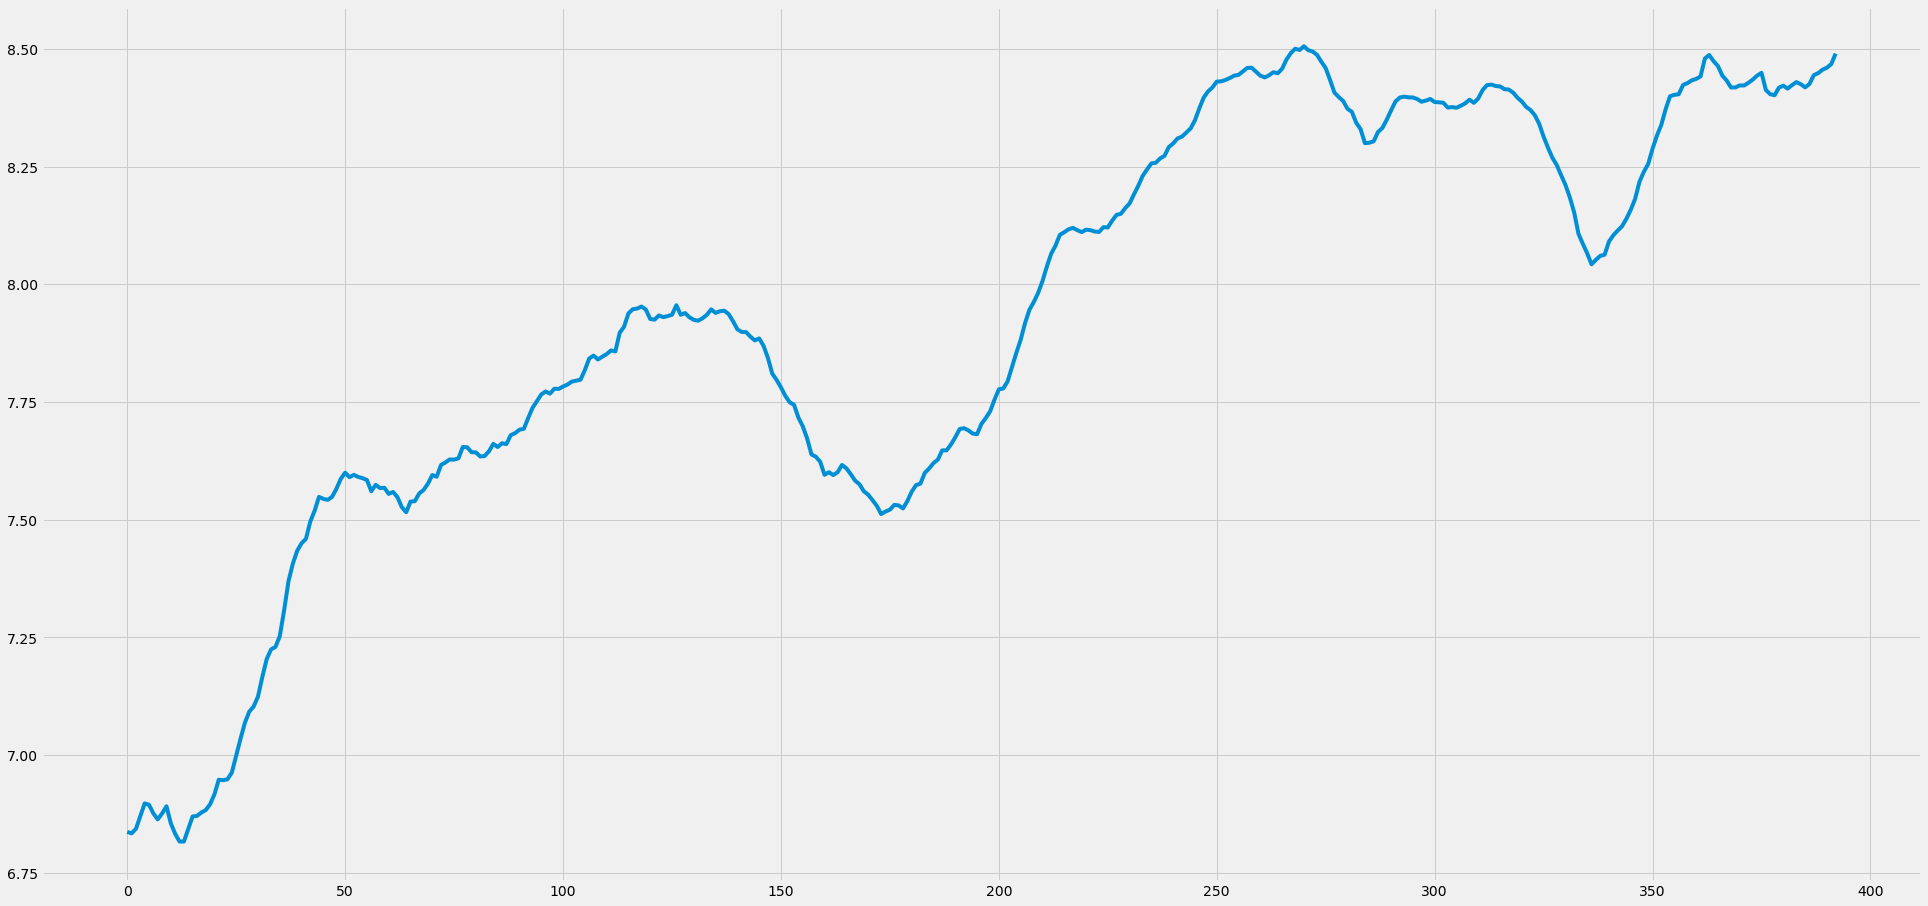

In [8]:
log_data = np.log(data)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (30, 15))
plt.plot(log_data.index, log_data['traffic'])

**Notice how the plot reduces the variance**

**The data is divided into to sets, the training and test set.**

In [9]:
msk = (log_data.index < len(log_data) - 30)
data_train = log_data[msk].copy()
data_test = log_data[~msk].copy()

In [10]:
#First order differencing
data_train_diff = data_train.diff().dropna()

Checking for stationarity of the data after differencing.

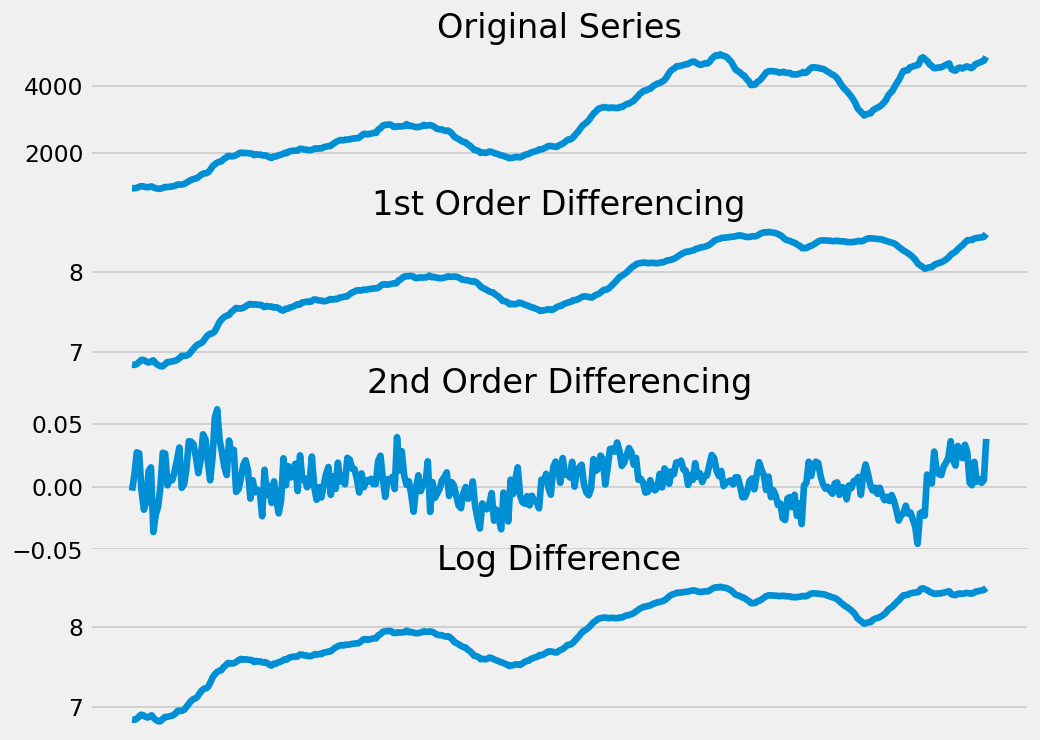

In [11]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
# Original Series
ax1.plot(data['traffic']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
#log difference
ax4.plot(log_data['traffic']); ax4.set_title('Log Difference'); ax4.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data_train['traffic']); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data_train['traffic'].diff().dropna()); ax3.set_title('2nd Order Differencing'); ax3.axes.xaxis.set_visible(False)
plt.show()

Notice how the 2nd differencing had too many noises, so we will just stick to 1st order differencing.

Using the ACF and PACF, we will also check for stationarity within the original data, 1st and 2nd order differencing.

In [12]:
#import the libraries
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [13]:
#1st differencing
data_diff = log_data.diff().dropna()

<function matplotlib.pyplot.show(close=None, block=None)>

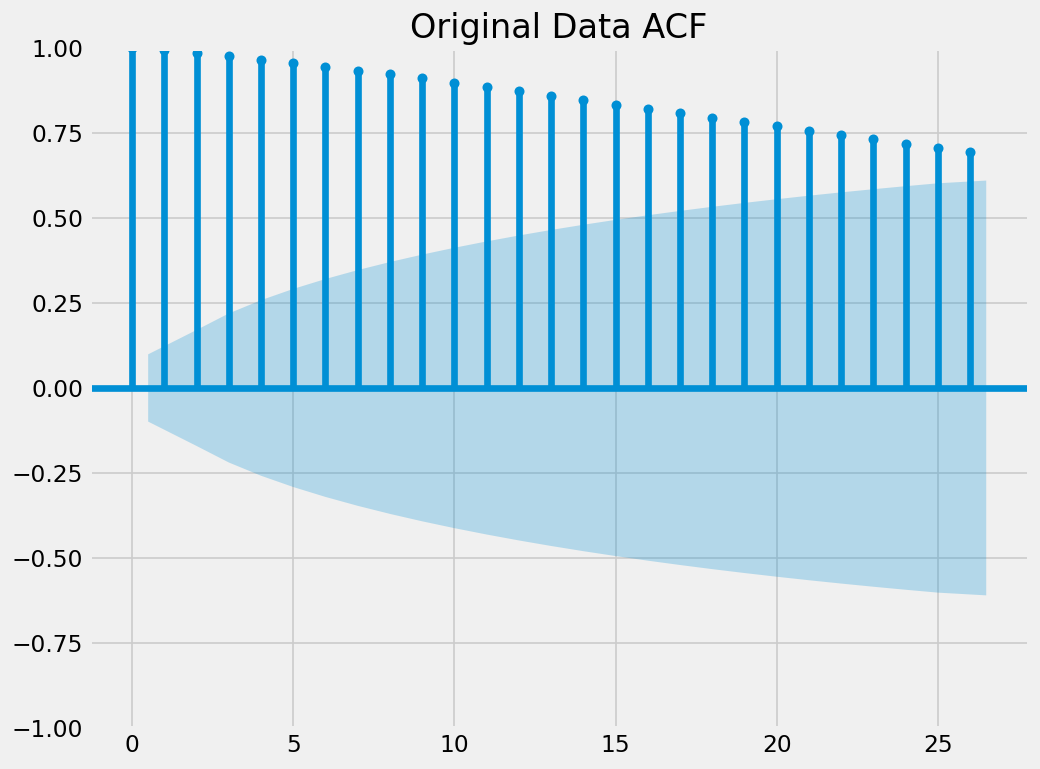

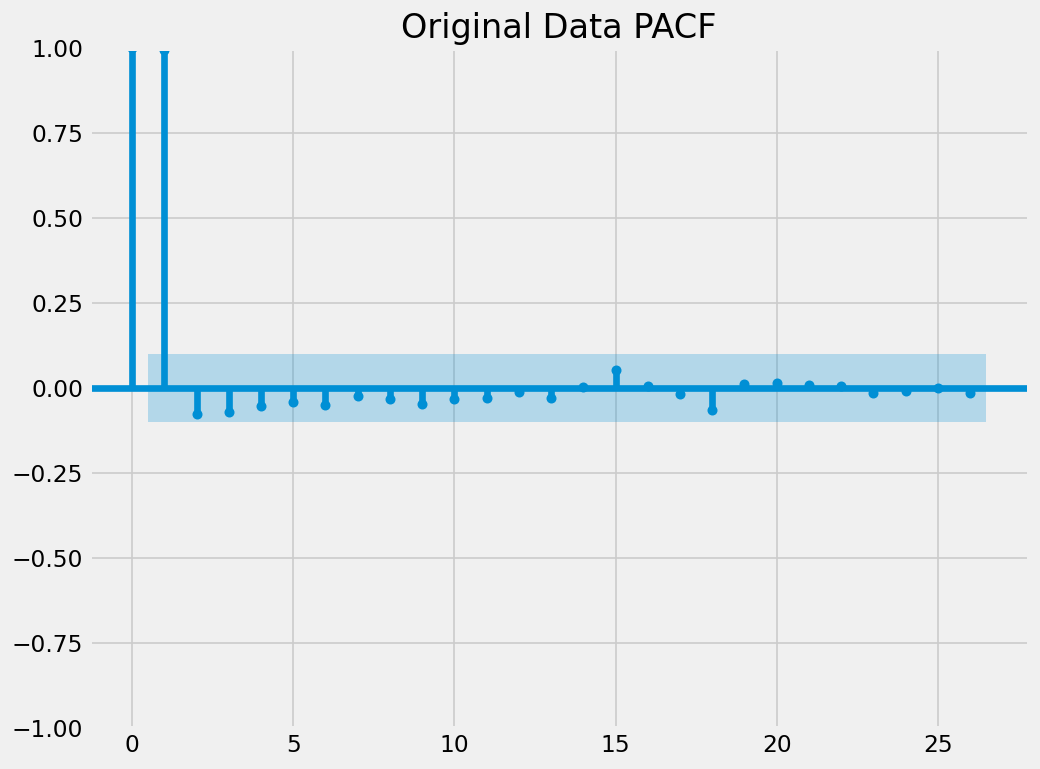

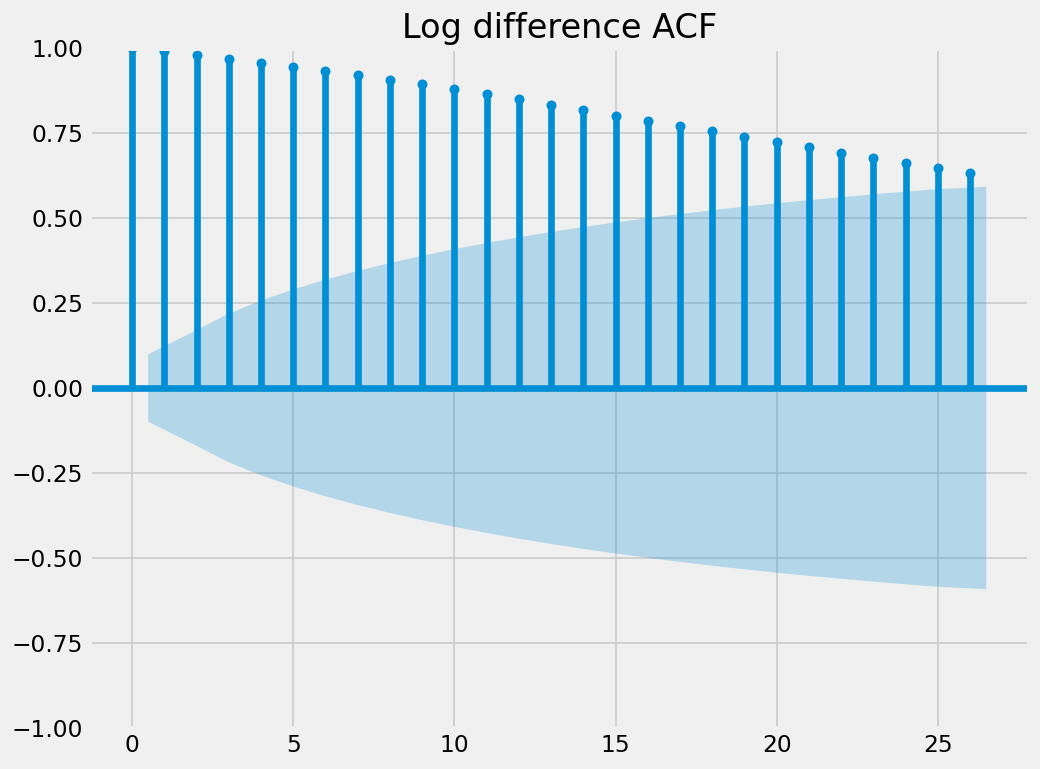

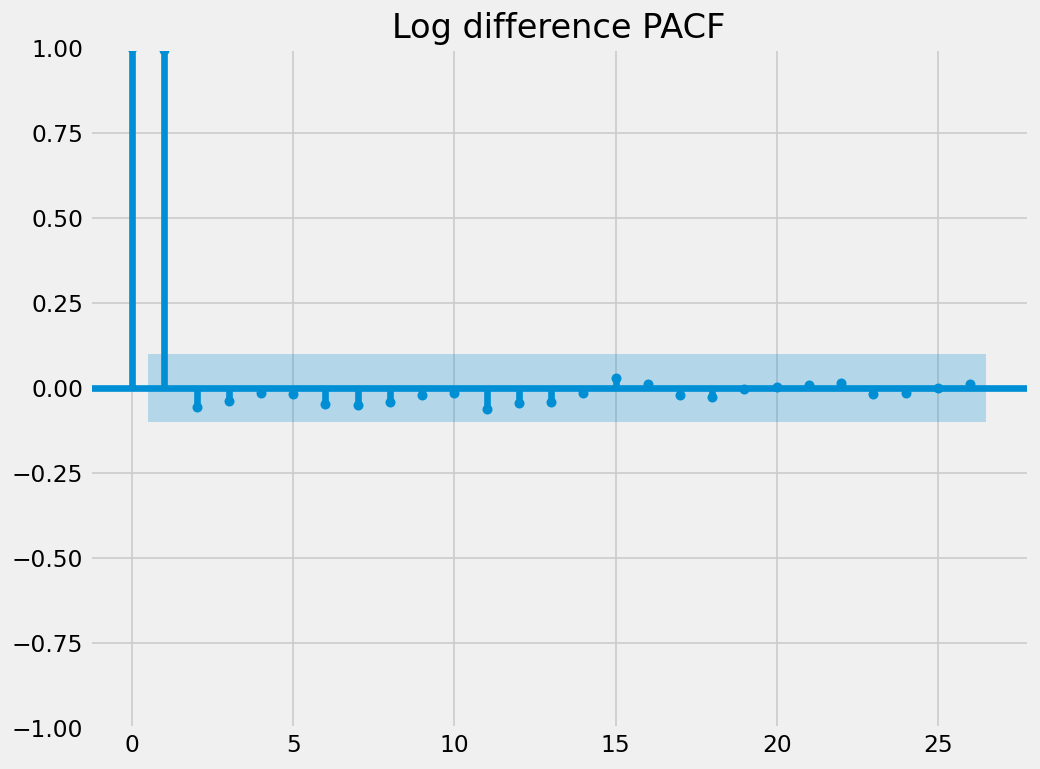

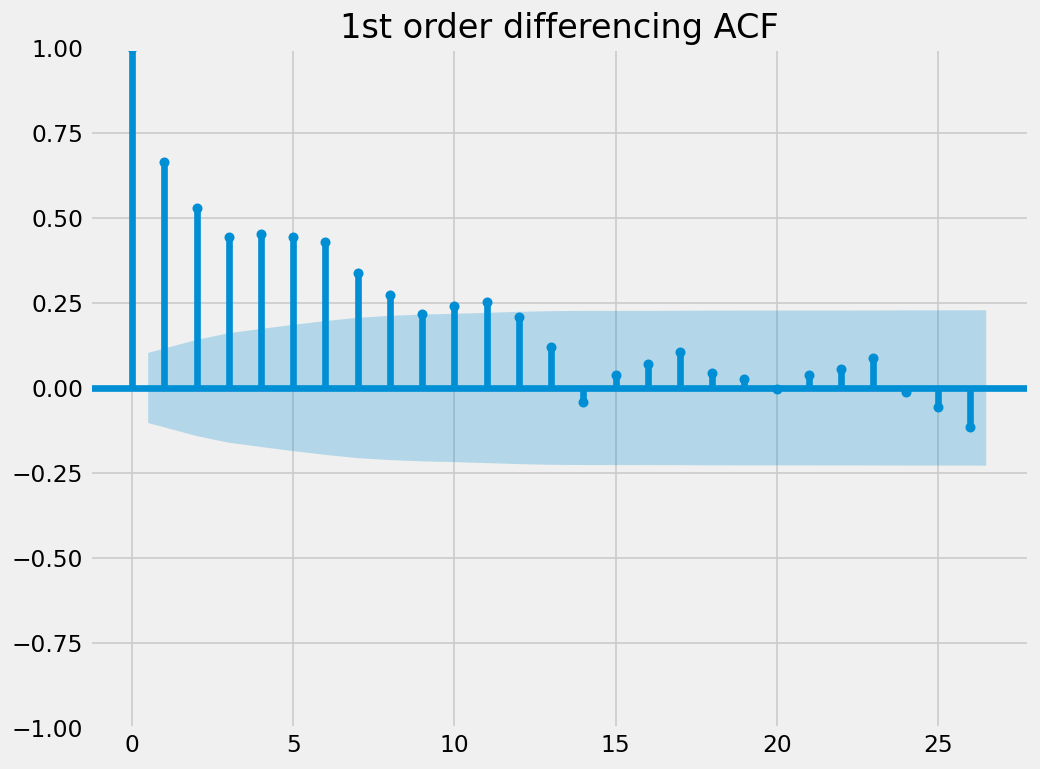

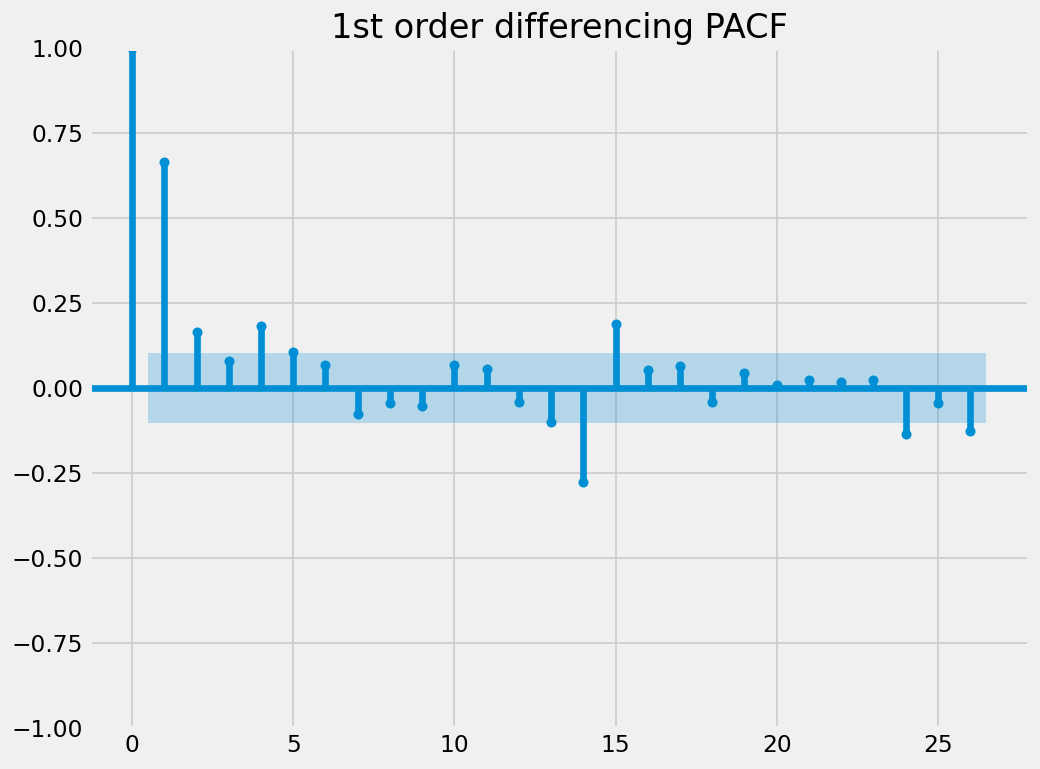

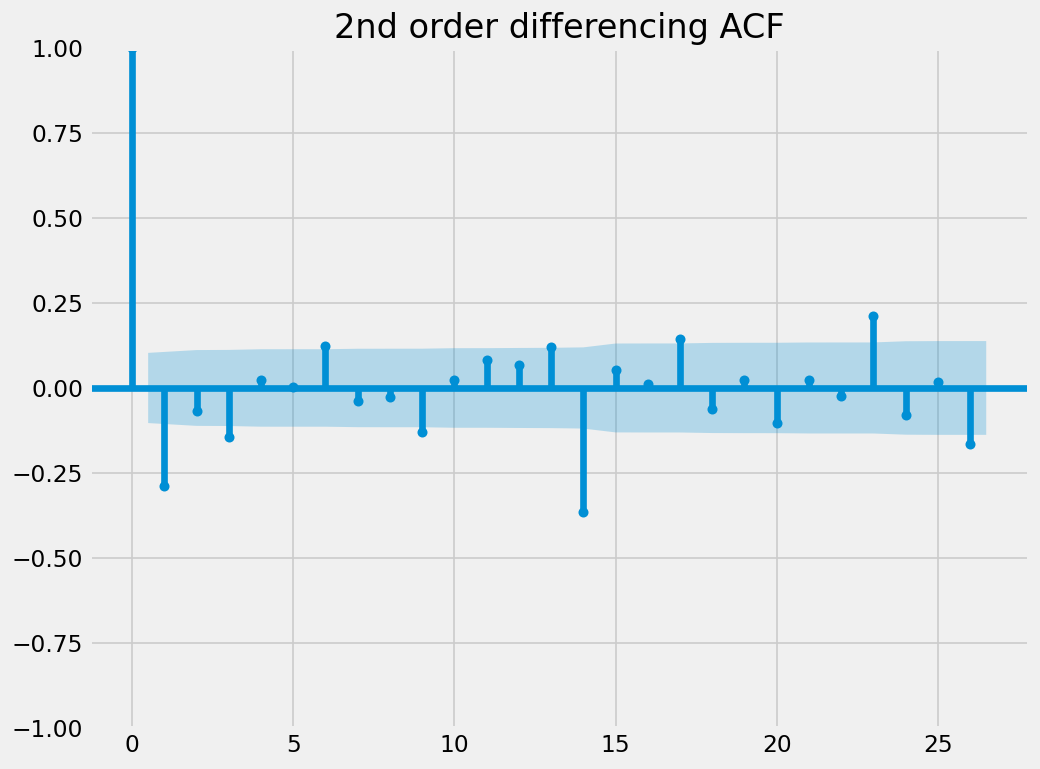

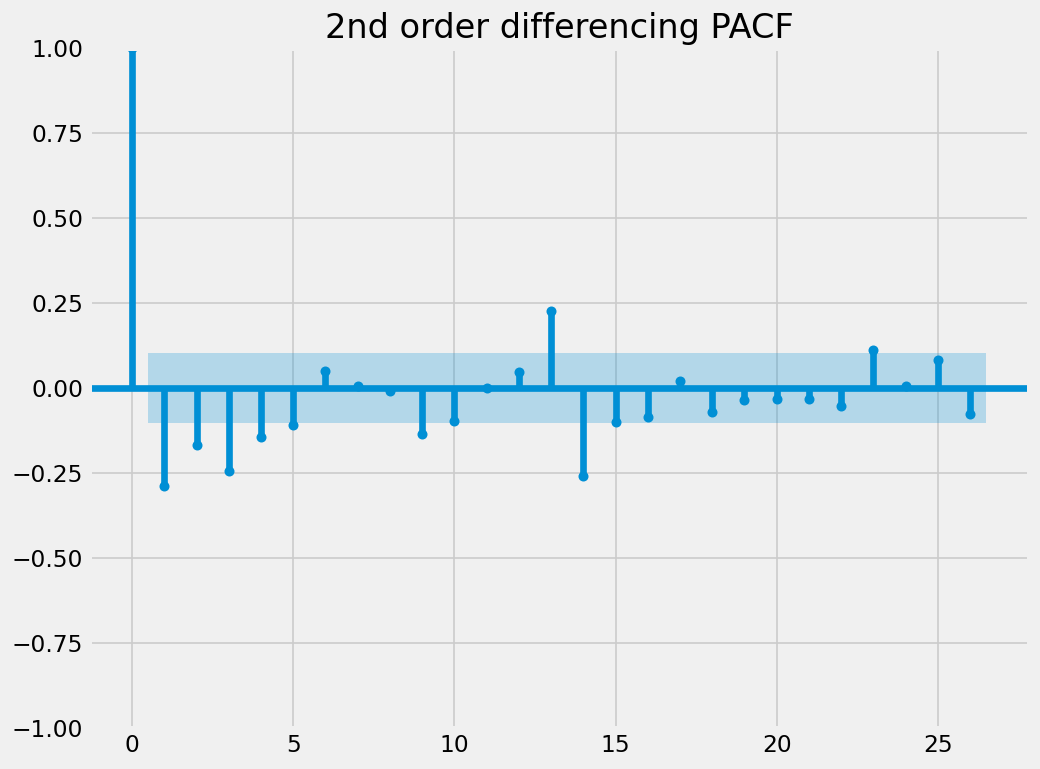

In [14]:
#ACF and PACF plot of the original data
plot_acf(data['traffic'], title = 'Original Data ACF')
plot_pacf(data['traffic'], title = 'Original Data PACF')
#Log differences
plot_acf(log_data['traffic'], title = 'Log difference ACF')
plot_pacf(log_data['traffic'], title = 'Log difference PACF')
#ACF and PACF plot of the 1st order differencing
plot_acf(data_train_diff['traffic'], title = '1st order differencing ACF')
plot_pacf(data_train_diff['traffic'], title = '1st order differencing PACF')
#ACF and PACF plot for 2nd order differencing
plot_acf(data_train_diff['traffic'].diff().dropna(), title = '2nd order differencing ACF')
plot_pacf(data_train_diff['traffic'].diff().dropna(), title = '2nd order differencing PACF')
plt.show

<font size=+1>**ADFULLER TEST**</font>

<font size=+1>Adfuller test is used to check for the stationarity of a given value. if the P value is lesser than 5% (0.05), the data is said to be stationary and the null hypothesis for non-stationarity is FALSE.</font>

In [15]:
#Import the adfuller test library
from statsmodels.tsa.stattools import adfuller

In [16]:
#Original test
adtest1 = adfuller(data['traffic'])
print(f'p-value: {adtest1[1]}')

p-value: 0.710514731518847


In [17]:
#1st order differencing 
adtest2 = adfuller(data_train_diff['traffic'])
print(f'p-value: {adtest2[1]}')

p-value: 0.022059461239126187


In [18]:
#2nd order differencing
adtest3 = adfuller(data_train_diff['traffic'].diff().dropna())
print(f'p-value: {adtest3[1]}')

p-value: 4.408731316121465e-09


<font size=+0.5, color =grey> The first order differencing is lower than 0.05, although 2nd order differencing is much lower than 1st order differencing, 1st order is used because it is much closer to 0.05 than 2nd order</font>

The values of order P,D,Q is determined using the ACF and PACF graph above

In [19]:
p = 2
d = 1
q = 0

<font size=+2>ARIMA</font>

In [20]:
#Import the libraries
from statsmodels.tsa.arima.model import ARIMA

In [21]:
model = ARIMA(data_train['traffic'], order=(p,d,q))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Fri, 30 Dec 2022   AIC                          -2186.737
Time:                        16:48:57   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

<font size=+1>From the Model_fit, we plot the value of the stationary residual to further determine if the data is now stationary</font>

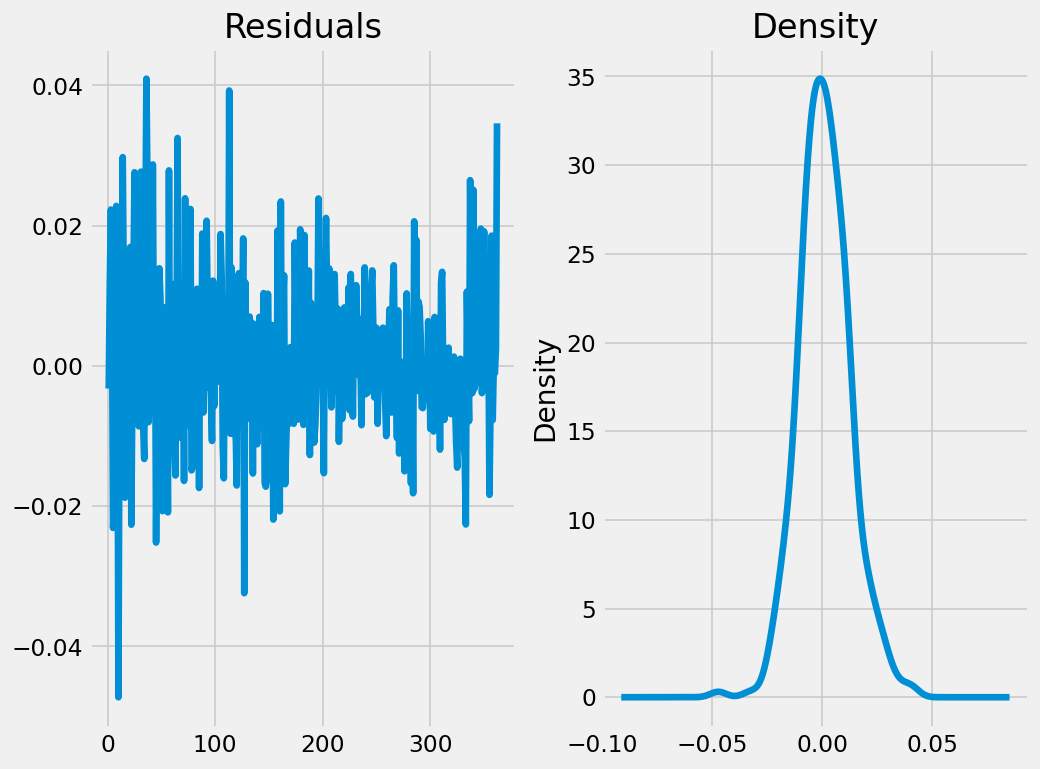

In [22]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

In [23]:
forecast1 = model_fit.forecast(len(data_test))

A graph is plotted to compare the test data and the predicted values 

In [24]:
data

,traffic
0,932
1,929
2,938
3,964
4,990
...,...
388,4667
389,4701
390,4721
391,4757


<AxesSubplot:>

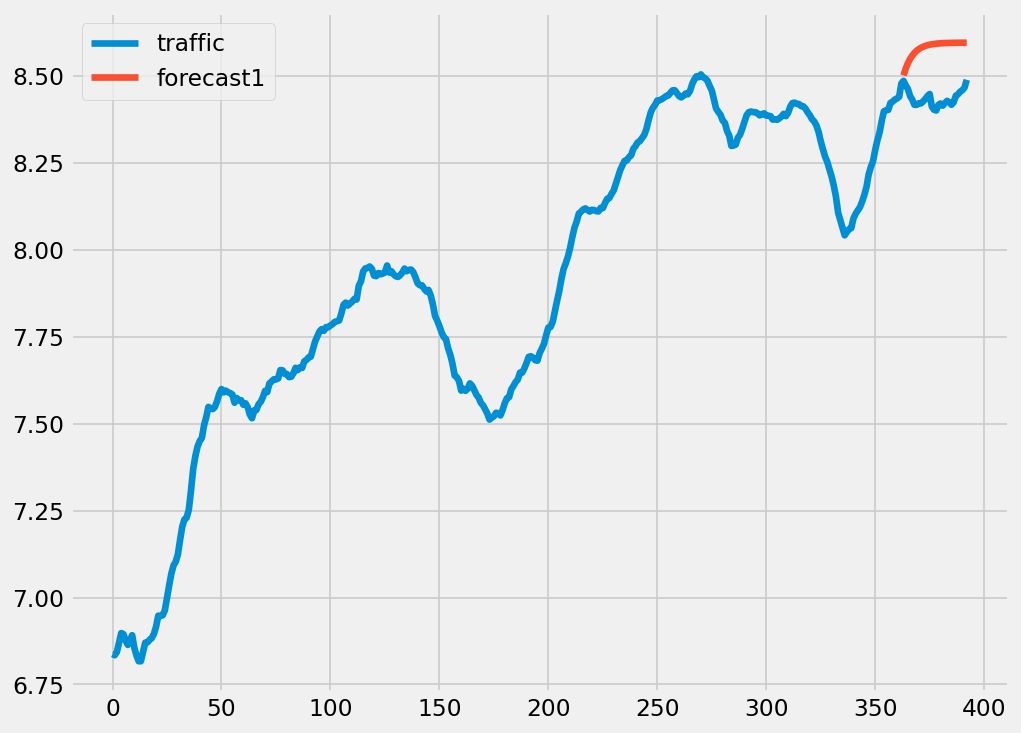

In [25]:
log_data['forecast1'] = [None]*len(data_train) + list(forecast1)
log_data[['traffic','forecast1']].plot()

<font size =+2> PMDARIMA</font>

Generating the values for p,d,q automactically using pmdarima

In [26]:
import pmdarima as pm

In [27]:
auto_arima = pm.auto_arima(data_train['traffic'], stepwise = False, seasonal = False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [28]:
model2 = ARIMA(data_train['traffic'], order=(5,1,0))
model_fit2 = model2.fit()
print(model_fit2.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(5, 1, 0)   Log Likelihood                1106.131
Date:                Fri, 30 Dec 2022   AIC                          -2200.263
Time:                        16:49:22   BIC                          -2176.913
Sample:                             0   HQIC                         -2190.981
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5242      0.052     10.099      0.000       0.423       0.626
ar.L2          0.1112      0.065      1.702      0.089      -0.017       0.239
ar.L3         -0.0315      0.064     -0.489      0.6

In [29]:
forecast2 = model_fit2.forecast(len(data_test))

<AxesSubplot:>

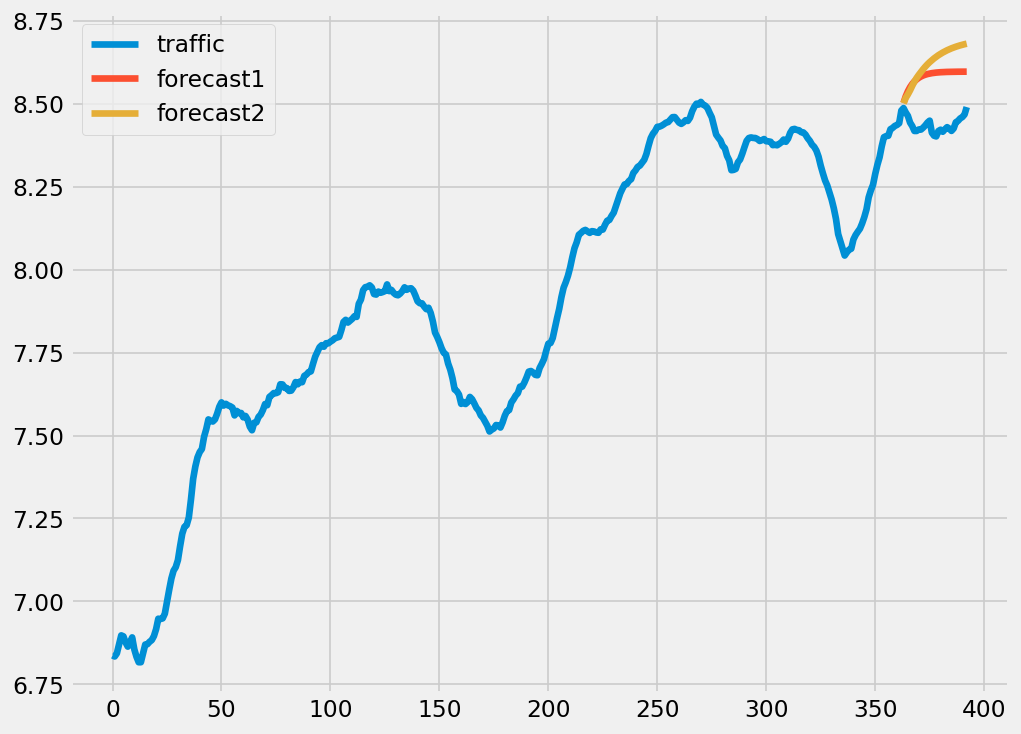

In [30]:
log_data['forecast2'] = [None]*len(data_train) + list(forecast2)
log_data[['traffic', 'forecast1', 'forecast2',]].plot()

Let's calculate for error.

In [31]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [32]:
mae = mean_absolute_error(data_test['traffic'], forecast1)
mape = mean_absolute_percentage_error(data_test['traffic'], forecast1)
rmse = np.sqrt(mean_squared_error(data_test['traffic'], forecast1))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 0.14514968349408738
mape - manual: 0.01721619846999954
rmse - manual: 0.15051403858280593


<font size=+1>Find the error for the auto generated orders</font>

In [33]:
mae1 = mean_absolute_error(data_test['traffic'], forecast2)
mape1 = mean_absolute_percentage_error(data_test['traffic'], forecast2)
rmse1 = np.sqrt(mean_squared_error(data_test['traffic'], forecast2))

print(f'mae - auto: {mae1}')
print(f'mape - auto: {mape1}')
print(f'rmse - auto: {rmse1}')

mae - auto: 0.18579231638567528
mape - auto: 0.022033681813555115
rmse - auto: 0.1956679310009207


In [46]:
import statsmodels.api as sm
model3 = sm.tsa.statespace.SARIMAX(data_train['traffic'], order = (p, d, q), seasonal_order = (p, d, q, 12)).fit()
print(model3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            traffic   No. Observations:                  363
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                1026.781
Date:                            Fri, 30 Dec 2022   AIC                          -2043.562
Time:                                    22:02:12   BIC                          -2024.272
Sample:                                         0   HQIC                         -2035.884
                                            - 363                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5082      0.051      9.968      0.000       0.408       0.608
ar.L2          0.2476      0.051   

In [48]:
sm_predict = model3.forecast(len(data_test))
log_data['seasonal'] = [None]*len(data_train) + list(sm_predict)

<AxesSubplot:>

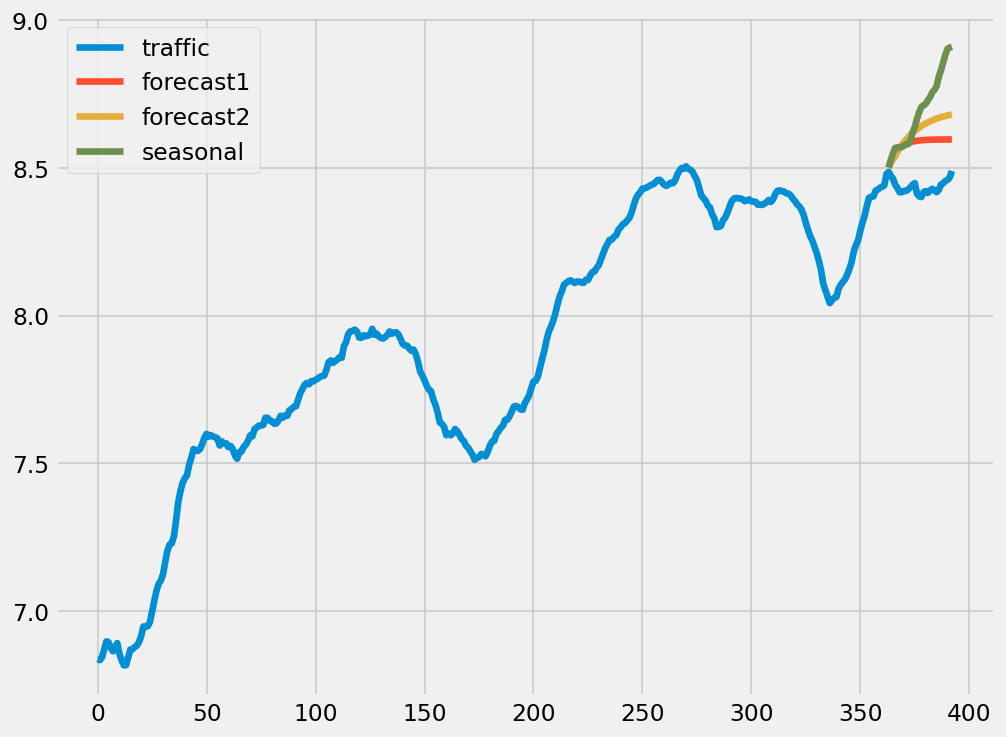

In [50]:
log_data[['traffic', 'forecast1', 'forecast2', 'seasonal']].plot()

<font size=+1>Measuring the errors.</font>

In [37]:
mae2 = mean_absolute_error(data_test['traffic'], sm_predict)
mape2 = mean_absolute_percentage_error(data_test['traffic'], sm_predict)
rmse2 = np.sqrt(mean_squared_error(data_test['traffic'], sm_predict))

print(f'mae - manual: {mae2}')
print(f'mape - manual: {mape2}')
print(f'rmse - manual: {rmse2}')

ValueError: Found input variables with inconsistent numbers of samples: [393, 30]